<a href="https://colab.research.google.com/github/renanalencar/projeto-cnn-squeezenet/blob/main/Projeto_CNN_Squeeze_vFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto de Redes Neurais 

## Referências: 

1. [Estudo sobre Câncer de Cólon utilizando a mesma base com modelod e CNN](https://www.kaggle.com/aayushrajput/lung-colon-cancer)
2. [Modelo de SqueezeNet para reconhecimento de comida](https://www.kaggle.com/kmader/food-squeezenet) 
3. [SqueezeNet no Keras](https://codelabs.developers.google.com/codelabs/keras-flowers-squeezenet#6)
4. [Entendendo Redes Convolucionais (CNNs) ](https://medium.com/neuronio-br/entendendo-redes-convolucionais-cnns-d10359f21184#:~:text=H%C3%A1%20muitas%20fun%C3%A7%C3%B5es%2C%20como%20sigmoid,quando%20comparada%20a%20outras%20fun%C3%A7%C3%B5es)
5. [Uma introdução as redes neurais convolucionais utilizando o Keras](https://medium.com/data-hackers/uma-introdu%C3%A7%C3%A3o-as-redes-neurais-convolucionais-utilizando-o-keras-41ee8dcc033e)
6. [Tutorial prático do Keras](https://cv-tricks.com/tensorflow-tutorial/keras/)
7. [Métricas de avaliação de modelo](https://gabrielschade.github.io/2019/03/12/ml-classificacao-metricas.html)


## Erro na biblioteca keras_applications

In [ ]:
!pip install keras_applications

## Importanto as bibliotecas necessárias

In [ ]:
import h5py
import numpy as np

import tensorflow as tf

from tensorflow.keras import datasets, layers, models

from keras import backend as K
from keras_applications.imagenet_utils import _obtain_input_shape
from keras.applications.vgg16 import VGG16
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.engine.topology import get_source_inputs
from keras.models import Model, model_from_json
from keras.layers import Dense,Flatten
from keras.layers import Input, Activation, concatenate
from keras.layers import Flatten, Dropout
from keras.layers import Dense,Flatten
from keras.layers import Convolution2D, MaxPooling2D,Conv2D
from keras.layers import AveragePooling2D, BatchNormalization
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import get_file
from keras.utils import layer_utils
from sklearn.metrics import f1_score,recall_score, precision_score, confusion_matrix
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('error')

# from visual_callbacks import AccLossPlotter

from google.colab import drive
drive.mount('/content/drive', force_remount=True)
%matplotlib inline

Exception ignored in: <_io.FileIO name=55 mode='wb' closefd=True>
Exception ignored in: <_io.FileIO name=56 mode='rb' closefd=True>


Mounted at /content/drive


## Pré-processamento

O conjunto de dados contém 15.000 imagens coloridas em 3 classes, com 5.000 imagens em cada classe. O conjunto de dados é dividido em 12.000 imagens de treinamento e 3.000 imagens de teste. 

### Variáveis 

In [ ]:
data_dir = '/content/drive/MyDrive/lung_image_sets_teste/' # Diretório das imagems 
width, height, nb_class = 768, 768, 3 # Dimensões da entrada
batch_size = 4 # Tamanho do lote para treinamento
shuffle = True # Sortear as amostras 
seed = 42 # Número de sementes 
nb_epoch = 1 # Número de épocas 
loss='categorical_crossentropy' # Algoritmo de optmização das Redes Convolucionais
optimizer_cnn='adam' # Algoritmo de optmização das Redes Convolucionais
optimizer_sn = 'sgd' # Algoritmo de optmização da SqueezeNet
metrics='accuracy' # Métrica utilizada 
target_size = (width, height)
input_shape =  (width, height, nb_class)

### Pré-processamento das imagens 

In [ ]:
def PreProcess(data_dir,target_size,batch_size,shuffle,seed):
    
    datagen_cnn = tf.keras.preprocessing.image.ImageDataGenerator(validation_split = 0.2)

    train_cnn = datagen_cnn.flow_from_directory(data_dir,
                                          class_mode = "categorical",
                                          target_size = target_size,
                                          color_mode="rgb",
                                          batch_size = batch_size, 
                                          shuffle = shuffle,
                                          subset='training',
                                          seed = seed)

    validation_cnn = datagen_cnn.flow_from_directory(data_dir,
                                          class_mode = "categorical",
                                          target_size = target_size,
                                          color_mode="rgb",
                                          batch_size = batch_size, 
                                          shuffle = shuffle,
                                          subset='validation',
                                          seed = seed)

    return train_cnn, validation_cnn 

## CNN

A saída de cada camada Conv2D e MaxPooling2D é um tensor 3D de forma (altura, largura, canais). As dimensões de altura e largura tendem a diminuir à medida que você se aprofunda na rede. O número de canais de saída para cada camada Conv2D é controlado pelo primeiro argumento (por exemplo, 32 ou 64). Normalmente, à medida que a largura e a altura diminuem, você pode (computacionalmente) adicionar mais canais de saída em cada camada Conv2D.

### Modelo de CNN 

As linhas de código abaixo definir a base convolucional utilizando um padrão comum: uma pilha de Conv2D e MaxPooling2D camadas.

Como entrada, um CNN assume tensores de forma (image_height, image_width, color_channels), ignorando o tamanho do lote. O color_channels se refere a (R, G, B). A CNN foi configuradapara processar entradas de forma (768, 768, 3), que é o formato de imagens lung_image_sets. 

In [ ]:
def Model_CNN():
  model = models.Sequential()

  # BatchNormalization()(inp) testar o BatchNormalization
  # Block 1
  model.add(layers.BatchNormalization(input_shape=(768, 768, 3)))
  # model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='block1_conv1', input_shape=(768, 768, 3))) # Original
  model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='block1_conv1'))
  model.add(layers.Conv2D(32, (1, 1), activation='relu',name='block1_conv2'))
  model.add(layers.MaxPooling2D((2, 2),strides=(2, 2), name='block1_pool'))

  # Block 2
  model.add(layers.Conv2D(64, (3, 3), activation='relu', name='block2_conv1'))
  model.add(layers.Conv2D(64, (1, 1), activation='relu',name='block2_conv2'))
  model.add(layers.MaxPooling2D((2, 2),strides=(2, 2), name='block2_pool'))

  # Block 3
  model.add(layers.Conv2D(128, (3, 3), activation='relu',name='block3_conv1'))
  model.add(layers.Conv2D(128, (1, 1), activation='relu',name='block3_conv2'))
  model.add(layers.MaxPooling2D((2, 2),strides=(2, 2), name='block3_pool'))

  # Block 4
  model.add(layers.Conv2D(256, (3, 3), activation='relu',name='block4_conv1'))
  model.add(layers.Conv2D(256, (1, 1), activation='relu',name='block4_conv2'))
  model.add(layers.MaxPooling2D((2, 2),strides=(2, 2), name='block4_pool'))

  # Block 5
  model.add(layers.Conv2D(512, (3, 3), activation='relu',name='block5_conv1'))
  model.add(layers.Conv2D(512, (1, 1), activation='relu',name='block5_conv2'))
  model.add(layers.MaxPooling2D((2, 2),strides=(2, 2), name='block5_pool'))

  # Flatten
  model.add(layers.Flatten())
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dense(256, activation='relu'))
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dense(3, activation='softmax'))
  
  return model

As (768, 768, 64) saídas serão achatadas em vetores de forma (387) antes de passar por duas camadas densas.

Para completar o modelo, o último tensor de saída da base convolucional (de formato (4, 4, 64)) em uma ou mais camadas Densas para realizar a classificação. Camadas densas recebem vetores como entrada (que são 1D), enquanto a saída atual é um tensor 3D. Primeiro, você nivelará (ou desenrolará) a saída 3D em 1D e, em seguida, adicionará uma ou mais camadas Densas na parte superior. O conjunto tem 3 classes de saída, então você usa uma camada Densa final com 3 saídas.

### Função para compilar o modelo da CNN

In [ ]:
def Compile_Model_CNN(loss, optimizer_cnn, metrics):
  model_cnn = Model_CNN()
  model_cnn.compile(loss=loss, optimizer=optimizer_cnn, metrics=[metrics])
  model_cnn.summary()
  return model_cnn

### Função de treinamento da CNN

In [ ]:
def Train_Model_CNN(model_cnn, train_cnn, nb_epoch, validation_cnn):
    history_cnn = model_cnn.fit(train_cnn, epochs = nb_epoch,  validation_data=validation_cnn)

    # salvar modelo para posterior avaliação      
    model_json = model_cnn.to_json()
    model_name = "Modelo_CNN"
    with open('/content/drive/MyDrive/'+model_name+".json", "w") as json_file:
        json_file.write(model_json)
    model_cnn.save_weights('/content/drive/MyDrive/'+model_name+'.h5')
    
    return history_cnn

### Função para execução da CNN

In [ ]:
def Execute_Model_CNN():
    train_cnn, validation_cnn = PreProcess(data_dir,target_size,batch_size,shuffle,seed)
    model_cnn = Compile_Model_CNN(loss, optimizer_cnn, metrics)
    
    history_cnn = Train_Model_CNN(model_cnn, train_cnn, nb_epoch, validation_cnn)
    
    # Plotar a curva de aprendizagem
    history_dict = history_cnn.history
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    accuracy = history_dict['accuracy']
    val_accuracy = history_dict['val_accuracy']
    
    epochs = range(1, len(loss_values) + 1)
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))

    # Plotar a Perdas vs Épocas
    ax.plot(epochs, loss_values, 'bo', label='Perda de treinamento')
    ax.plot(epochs, val_loss_values, 'b', label='Perda de validação')
    ax.set_title('Perdas de Treinamento & Validação', fontsize=16)
    ax.set_xlabel('Épocas', fontsize=16)
    ax.set_ylabel('Perdas', fontsize=16)
    ax.legend()

    ax.figure.savefig('/content/drive/MyDrive/Curva_de_aprendizagem_CNN.png')
  

### Função para avaliação  da CNN

In [ ]:
def Evaluate_Model_CNN():

    train_cnn, validation_cnn = PreProcess(data_dir,target_size,batch_size,shuffle,seed)

    # Recuperando o modelo Treinado da CNN
    with open('/content/drive/MyDrive/Modelo_CNN.json','r') as modelo:
      json = modelo.read()
    model_cnn = model_from_json(json)

    # Recuperando os pesos do treinamento da CNN
    model_cnn.load_weights('/content/drive/MyDrive/Modelo_CNN.h5') 

    # predicted_cnn = model_cnn.predict(validation_cnn)

    # Y_pred = model_cnn.predict_generator(validation_cnn, steps=4500 // batchsize+1)
    Y_pred = model_cnn.predict(validation_cnn)
    y_pred = np.argmax(Y_pred, axis=1)
    
    print('\nMatriz de Confusão')
    print(confusion_matrix(validation_cnn.classes, y_pred),'\n')

    print(" ---- F1 Score ----")
    print(f1_score(validation_cnn.classes, y_pred, average = 'micro'))
    print(f1_score(validation_cnn.classes, y_pred, average = 'macro'))
    print(f1_score(validation_cnn.classes, y_pred, average = 'weighted'),'\n')

    print(" ---- Recall ----")
    print(recall_score(validation_cnn.classes, y_pred, average = 'micro'))
    print(recall_score(validation_cnn.classes, y_pred, average = 'macro'))
    print(recall_score(validation_cnn.classes, y_pred, average = 'weighted'),'\n')
    
    print(" ---- Precision ----")
    print(precision_score(validation_cnn.classes, y_pred, average = 'micro', zero_division=1))
    print(precision_score(validation_cnn.classes, y_pred, average = 'macro', zero_division=1))
    print(precision_score(validation_cnn.classes, y_pred, average = 'weighted', zero_division=1),'\n')

### Chamada para execução da CNN

Found 120 images belonging to 3 classes.
Found 30 images belonging to 3 classes.
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_7 (Batch (None, 768, 768, 3)       12        
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 768, 768, 32)      896       
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 768, 768, 32)      1056      
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 384, 384, 32)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 382, 382, 64)      18496     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 382, 382, 64)      4160      
_______________________________________

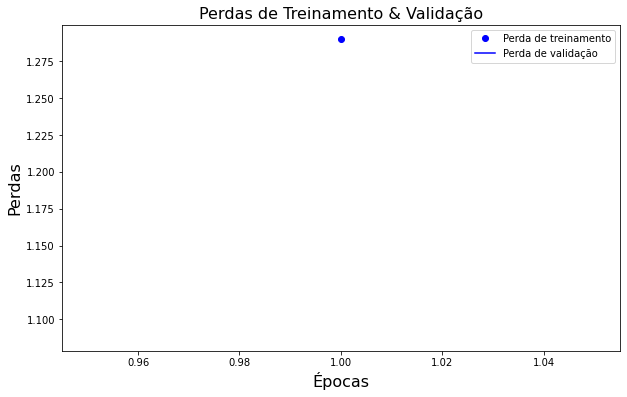

In [ ]:
Execute_Model_CNN()

### Chamada para avaliação da CNN




In [ ]:
Evaluate_Model_CNN()

Found 120 images belonging to 3 classes.
Found 30 images belonging to 3 classes.

Matriz de Confusão
[[ 0  0 10]
 [ 0  0 10]
 [ 0  0 10]] 

 ---- F1 Score ----
0.3333333333333333
0.16666666666666666
0.16666666666666666 

 ---- Recall ----
0.3333333333333333
0.3333333333333333
0.3333333333333333 

 ---- Precision ----
0.3333333333333333
0.7777777777777778
0.7777777777777778 



# VGG

### Modelo VGG

In [ ]:
def Model_VGG():
  model = VGG16(include_top=False, input_shape=(768, 768, 3))

  for layer in model.layers:
   layer.trainable = False
  
  flat1 = Flatten()(model.layers[-1].output)
  class1 = Dense(1024, activation='relu')(flat1)
  class2 = Dense(512, activation='relu')(class1)
  class3 = Dense(256, activation='relu')(class2)
  class4 = Dense(128, activation='relu')(class3)
  output = Dense(3, activation='softmax')(class4)

  model = Model(inputs=model.inputs, outputs=output)

  return model

### Função para compilar o modelo da VGG

In [ ]:
def Compile_Model_VGG(loss, optimizer_cnn, metrics):
  
  model_vgg = Model_VGG()
  model_vgg.compile(loss=loss, optimizer=optimizer_cnn, metrics=[metrics])
  model_cnn.summary()

  return model_vgg

### Função de treinamento da VGG

In [ ]:
def Train_Model_VGG(model_vgg, train_cnn, nb_epoch, validation_cnn):
     
     history_vgg = model_vgg.fit(train_cnn, epochs = nb_epoch,  validation_data=validation_cnn)

     # salvar modelo para posterior avaliação      
     model_json = model_vgg.to_json()
     model_name = "Modelo_VGG"
     with open('/content/drive/MyDrive/'+model_name+".json", "w") as json_file:
      json_file.write(model_json)
     model_vgg.save_weights('/content/drive/MyDrive/'+model_name+'.h5')

     return history_vgg

### Função para execução da VGG

In [ ]:
def Execute_Model_VGG():
  
    train_cnn, validation_cnn = PreProcess(data_dir,target_size,batch_size,shuffle,seed)
    model_vgg = Compile_Model_VGG(loss, optimizer_cnn, metrics)
    model_vgg, history_vgg = Train_Model_VGG(model_vgg, train_cnn, nb_epoch, validation_cnn)

    # Plotar a curva de aprendizagem
    history_dict = history_vgg.history
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    accuracy = history_dict['accuracy']
    val_accuracy = history_dict['val_accuracy']
    
    epochs = range(1, len(loss_values) + 1)
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))

    # Plotar a Perdas vs Épocas
    ax.plot(epochs, loss_values, 'bo', label='Perda de treinamento')
    ax.plot(epochs, val_loss_values, 'b', label='Perda de validação')
    ax.set_title('Perdas de Treinamento & Validação', fontsize=16)
    ax.set_xlabel('Épocas', fontsize=16)
    ax.set_ylabel('Perdas', fontsize=16)
    ax.legend()

    ax.figure.savefig('/content/drive/MyDrive/Curva_de_aprendizagem_VGG.png')
  

### Função para avaliação  da VGG

In [ ]:
def Evaluate_Model_VGG():

    train_cnn, validation_cnn = PreProcess(data_dir,target_size,batch_size,shuffle,seed)

    # Recuperando o modelo Treinado da CNN
    with open('/content/drive/MyDrive/Modelo_VGG.json','r') as modelo:
      json = modelo.read()
    model_vgg = model_from_json(json)

    # Recuperando os pesos do treinamento da CNN
    model_vgg.load_weights('/content/drive/MyDrive/Modelo_VGG.h5') 

    Y_pred = model_vgg.predict(validation_cnn)
    y_pred = np.argmax(Y_pred, axis=1)
    
    print('\nMatriz de Confusão')
    print(confusion_matrix(validation_cnn.classes, y_pred),'\n')

    print(" ---- F1 Score ----")
    print(f1_score(validation_cnn.classes, y_pred, average = 'micro'))
    print(f1_score(validation_cnn.classes, y_pred, average = 'macro'))
    print(f1_score(validation_cnn.classes, y_pred, average = 'weighted'),'\n')

    print(" ---- Recall ----")
    print(recall_score(validation_cnn.classes, y_pred, average = 'micro'))
    print(recall_score(validation_cnn.classes, y_pred, average = 'macro'))
    print(recall_score(validation_cnn.classes, y_pred, average = 'weighted'),'\n')
    
    print(" ---- Precision ----")
    print(precision_score(validation_cnn.classes, y_pred, average = 'micro'))
    print(precision_score(validation_cnn.classes, y_pred, average = 'macro'))
    print(precision_score(validation_cnn.classes, y_pred, average = 'weighted', zero_division=1),'\n')

### Chamada para execução da VGG

In [ ]:
Execute_Model_VGG()

### Chamada para avaliação da VGG

In [ ]:
Evaluate_Model_VGG()

Found 120 images belonging to 3 classes.
Found 30 images belonging to 3 classes.

Matriz de Confusão
[[5 3 2]
 [4 3 3]
 [3 4 3]] 

 ---- F1 Score ----
0.36666666666666664
0.36262626262626263
0.3626262626262626 

 ---- Recall ----
0.36666666666666664
0.3666666666666667
0.36666666666666664 

 ---- Precision ----
0.36666666666666664
0.36388888888888893
0.36388888888888893 



# SqueezeNet

### Modelo SqueezeNet

In [ ]:
sq1x1 = "squeeze1x1"
exp1x1 = "expand1x1"
exp3x3 = "expand3x3"
relu = "relu_"

WEIGHTS_PATH = "https://github.com/rcmalli/keras-squeezenet/releases/download/v1.0/squeezenet_weights_tf_dim_ordering_tf_kernels.h5"
WEIGHTS_PATH_NO_TOP = "https://github.com/rcmalli/keras-squeezenet/releases/download/v1.0/squeezenet_weights_tf_dim_ordering_tf_kernels_notop.h5"

def fire_module(x, fire_id, squeeze=16, expand=64):
    s_id = 'fire' + str(fire_id) + '/'

    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = 3
    
    x = Convolution2D(squeeze, (1, 1), padding='valid', name=s_id + sq1x1)(x)
    x = Activation('relu', name=s_id + relu + sq1x1)(x)

    left = Convolution2D(expand, (1, 1), padding='valid', name=s_id + exp1x1)(x)
    left = Activation('relu', name=s_id + relu + exp1x1)(left)

    right = Convolution2D(expand, (3, 3), padding='same', name=s_id + exp3x3)(x)
    right = Activation('relu', name=s_id + relu + exp3x3)(right)

    x = concatenate([left, right], axis=channel_axis, name=s_id + 'concat')
    return x


def Model_SqzNet(include_top=True, weights='imagenet', 
               input_tensor=None, input_shape=None,
               pooling=None,
               use_bn_on_input = False,
               classes=1000):
    """Instantiates the SqueezeNet architecture.
    """
        
    if weights not in {'imagenet', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `imagenet` '
                         '(pre-training on ImageNet).')

    if weights == 'imagenet' and classes != 1000:
        raise ValueError('If using `weights` as imagenet with `include_top`'
                         ' as true, `classes` should be 1000')


    input_shape = _obtain_input_shape(input_shape,
                                      default_size=227,
                                      min_size=48,
                                      data_format=K.image_data_format(),
                                      require_flatten=include_top)

    if input_tensor is None:
        raw_img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    if use_bn_on_input:
        img_input = BatchNormalization()(raw_img_input)
    else:
        img_input = raw_img_input

    x = Convolution2D(64, (3, 3), strides=(2, 2), padding='valid', name='conv1')(img_input)
    x = Activation('relu', name='relu_conv1')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool1')(x)

    x = fire_module(x, fire_id=2, squeeze=16, expand=64)
    x = fire_module(x, fire_id=3, squeeze=16, expand=64)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool3')(x)

    x = fire_module(x, fire_id=4, squeeze=32, expand=128)
    x = fire_module(x, fire_id=5, squeeze=32, expand=128)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool5')(x)

    x = fire_module(x, fire_id=6, squeeze=48, expand=192)
    x = fire_module(x, fire_id=7, squeeze=48, expand=192)
    x = fire_module(x, fire_id=8, squeeze=64, expand=256)
    x = fire_module(x, fire_id=9, squeeze=64, expand=256)
    
    if include_top:
    
        x = Dropout(0.5, name='drop9')(x)

        x = Convolution2D(classes, (1, 1), padding='valid', name='conv10')(x)
        x = Activation('relu', name='relu_conv10')(x)
        x = GlobalAveragePooling2D()(x)
        x = Activation('softmax', name='loss')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling=='max':
            x = GlobalMaxPooling2D()(x)
        elif pooling==None:
            pass
        else:
            raise ValueError("Unknown argument for 'pooling'=" + pooling)

    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input

    model = Model(inputs, x, name='squeezenet')

    if weights == 'imagenet':
        if include_top:
            weights_path = get_file('squeezenet_weights_tf_dim_ordering_tf_kernels.h5',
                                    WEIGHTS_PATH,
                                    cache_subdir='models')
        else:
            weights_path = get_file('squeezenet_weights_tf_dim_ordering_tf_kernels_notop.h5',
                                    WEIGHTS_PATH_NO_TOP,
                                    cache_subdir='models')
            
        model.load_weights(weights_path)
        if K.backend() == 'theano':
            layer_utils.convert_all_kernels_in_model(model)

        if K.image_data_format() == 'channels_first':

            if K.backend() == 'tensorflow':
                print('You are using the TensorFlow backend, yet you '
                              'are using the Theano '
                              'image data format convention '
                              '(`image_data_format="channels_first"`). '
                              'For best performance, set '
                              '`image_data_format="channels_last"` in '
                              'your Keras config '
                              'at ~/.keras/keras.json.')
    return model

### Função para compilar o modelo da SqueezeNet

In [ ]:
def Compile_Model_SqzNet(input_shape, nb_class, loss, optimizer_sn, metrics):
 
  model_sn = Model_SqzNet(input_shape=input_shape,  weights=None, classes = nb_class)
  sgd = SGD(lr=0.001, decay=0.0002, momentum=0.9, nesterov=True)
  model_sn.compile(loss=loss, optimizer=optimizer_sn, metrics=[metrics])
  model_sn.summary()

  return model_sn

### Função para treinamento  da SqueezeNet

In [ ]:
def Train_Model_SqzNet(model_sn, train_cnn, nb_epoch, validation_cnn):
    
    history_sn = model_sn.fit(train_cnn, epochs = nb_epoch,  validation_data=validation_cnn)

    # salvar modelo para posterior avaliação      
    model_json = model_sn.to_json()
    model_name = "Modelo_SqzNet"
    with open('/content/drive/MyDrive/'+model_name+".json", "w") as json_file:
      json_file.write(model_json)
    model_sn.save_weights('/content/drive/MyDrive/'+model_name+'.h5')

    return history_sn

### Função para execuação  da SqueezeNet

In [ ]:
def Execute_Model_SqzNet():
    
    train_cnn, validation_cnn = PreProcess(data_dir,target_size,batch_size,shuffle,seed)
    model_sn = Compile_Model_SqzNet(input_shape, nb_class, loss, optimizer_sn, metrics)
    history_sn = Train_Model_SqzNet(model_sn, train_cnn, nb_epoch, validation_cnn)

    # Plotar a curva de aprendizagem
    history_dict = history_sn.history
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    accuracy = history_dict['accuracy']
    val_accuracy = history_dict['val_accuracy']
    
    epochs = range(1, len(loss_values) + 1)
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))

    # Plotar a Perdas vs Épocas
    ax.plot(epochs, loss_values, 'bo', label='Perda de treinamento')
    ax.plot(epochs, val_loss_values, 'b', label='Perda de validação')
    ax.set_title('Perdas de Treinamento & Validação', fontsize=16)
    ax.set_xlabel('Épocas', fontsize=16)
    ax.set_ylabel('Perdas', fontsize=16)
    ax.legend()

    ax.figure.savefig('/content/drive/MyDrive/Curva_de_aprendizagem_SqzNet.png')

### Função para avaliação  da SqueezeNet

In [ ]:
def Evaluate_Model_SqzNet():
    
    train_cnn, validation_cnn = PreProcess(data_dir,target_size,batch_size,shuffle,seed)

    # Recuperando o modelo Treinado da CNN
    with open('/content/drive/MyDrive/Modelo_SqzNet.json','r') as modelo:
      json = modelo.read()
    model_vgg = model_from_json(json)

    # Recuperando os pesos do treinamento da CNN
    model_vgg.load_weights('/content/drive/MyDrive/Modelo_SqzNet.h5') 

    Y_pred = model_vgg.predict(validation_cnn)
    y_pred = np.argmax(Y_pred, axis=1)
    
    print('\nMatriz de Confusão')
    print(confusion_matrix(validation_cnn.classes, y_pred),'\n')

    print(" ---- F1 Score ----")
    print(f1_score(validation_cnn.classes, y_pred, average = 'micro'))
    print(f1_score(validation_cnn.classes, y_pred, average = 'macro'))
    print(f1_score(validation_cnn.classes, y_pred, average = 'weighted'),'\n')

    print(" ---- Recall ----")
    print(recall_score(validation_cnn.classes, y_pred, average = 'micro'))
    print(recall_score(validation_cnn.classes, y_pred, average = 'macro'))
    print(recall_score(validation_cnn.classes, y_pred, average = 'weighted'),'\n')
    
    print(" ---- Precision ----")
    print(precision_score(validation_cnn.classes, y_pred, average = 'micro', zero_division=1))
    print(precision_score(validation_cnn.classes, y_pred, average = 'macro', zero_division=1))
    print(precision_score(validation_cnn.classes, y_pred, average = 'weighted', zero_division=1),'\n')

### Chamada para execução da SqueezeNet

In [ ]:
Execute_Model_SqzNet()

### Chamada para avaliação da SqueezeNet

In [ ]:
Evaluate_Model_SqzNet()